# GRU 304
Start with GRU 301 which did train on long, test on short.
Here train on long, test on all.

In [1]:
TRAIN_NC_FILENAME='ncRNA.gc36.long.fasta'
TRAIN_PC_FILENAME='pcRNA.gc36.long.fasta'
VALID_NC_FILENAME='ncRNA.gc36.all.fasta'
VALID_PC_FILENAME='pcRNA.gc36.all.fasta'
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='JUNK2'  # change this if you want to keep models
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
TRAIN_NC_FILENAME = DATAPATH+TRAIN_NC_FILENAME
TRAIN_PC_FILENAME = DATAPATH+TRAIN_PC_FILENAME
VALID_NC_FILENAME = DATAPATH+VALID_NC_FILENAME
VALID_PC_FILENAME = DATAPATH+VALID_PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200
SPLITS=5
ONEHOT=5  
NEURONS=64
DROP=0.10
ACT="tanh"
MINLEN=201
MAXLEN=2000
LIMIT=5588    # This is the size of our smallest set (protein coding short)

Mounted at /content/drive/


In [2]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    MASK=[0,0,0,0,1] # to do: get one_hot('N') from the one_hot() function.
    mask_layer = keras.layers.Masking(mask_value=MASK, input_shape=[MAXLEN,ONEHOT])
    rlayer1 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP )  
    rlayer2 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer3 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer4 = keras.layers.GRU(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) 

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    rnn = keras.models.Sequential()
    rnn.add(mask_layer)
    rnn.add(rlayer1)
    rnn.add(rlayer2)
    rnn.add(rlayer3)
    rnn.add(rlayer4)
    rnn.add(dlayer1)
    rnn.add(dlayer2)
    rnn.add(dlayer3)
    rnn.add(dlayer4)
    rnn.add(output_layer)
    compiled = compile_model(rnn)
    return compiled

Cross validation

In [5]:
def do_cross_validation(X_train,y_train,given_model,X_valid,y_valid):
    cv_scores = []
    fold=0
    # When not using ShuffleSplit, make sure to randomize train data.
    #splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    #for train_index,valid_index in splitter.split(X):
    while fold < SPLITS:
        fold += 1
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        es = keras.callbacks.EarlyStopping(monitor='val_loss',  
            patience=10, verbose=1)
        mc = keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')  
        mycallbacks = [es,mc]  
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks, shuffle=True,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  

    print()
    print("%d-way Cross Validation max %.2f%%, mean %.2f%% (+/- %.2f%%)" % 
          (fold, np.amax(cv_scores), np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [6]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 2000, 5)           0         
_________________________________________________________________
gru (GRU)                    (None, 2000, 64)          13632     
_________________________________________________________________
gru_1 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_2 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_____________________________________________________________

In [7]:
def load_data(nc_filename,pc_filename,limit=None):
  nc_seq=tools.load_fasta(nc_filename,0)
  pc_seq=tools.load_fasta(pc_filename,1)
  if limit is not None:
    # Choose a random subset of size = limit.
    # Side effect: randomizes the data order.
    nfrac=1.0*limit/len(nc_seq)
    pfrac=1.0*limit/len(pc_seq)
    if nfrac<1.0:
      nc_seq=nc_seq.sample(frac=nfrac)
    if pfrac<1.0:
      pc_seq=pc_seq.sample(frac=pfrac)
  train_set=pd.concat((nc_seq,pc_seq),axis=0)
  # May not need to slice by length if input files already sliced
  subset=tools.make_slice(train_set,MINLEN,MAXLEN)
  # randset=subset.sample(frac=1) # unneccessary with fit(shuffle)
  (X1,y1)=tools.separate_X_and_y(subset)
  # X1 is pandas df of ("list" of one sequence)
  X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
  X3=[elem[0] for elem in X2]  # numpy dnarray of str
  X4=tools.uniform_length(X3,MAXLEN)
  X5= [tools.one_hot(x) for x in X4]  
  # one-hot leaves ONEHOT=5. TO DO: set 5 automatically
  X6=np.asarray(X5)
  y6=y1.to_numpy()
  return X6,y6

print("Load train data from files.")
X_train,y_train = load_data(TRAIN_NC_FILENAME,TRAIN_PC_FILENAME,LIMIT)
print("X_train",X_train.shape)
print(X_train[1])
print("Load valid data from files.")
X_valid,y_valid = load_data(VALID_NC_FILENAME,VALID_PC_FILENAME,LIMIT)
print("X_valid",X_valid.shape)

Load train data from files.
X_train (11176, 2000, 5)
[[0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Load valid data from files.
X_valid (11176, 2000, 5)


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 157s 398ms/step - loss: 0.6938 - accuracy: 0.5163 - val_loss: 0.6865 - val_accuracy: 0.5516


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 2/200
350/350 [==============================] - 138s 394ms/step - loss: 0.6880 - accuracy: 0.5452 - val_loss: 0.6893 - val_accuracy: 0.5374
Epoch 3/200
350/350 [==============================] - 139s 399ms/step - loss: 0.6883 - accuracy: 0.5440 - val_loss: 0.7004 - val_accuracy: 0.5137
Epoch 4/200
350/350 [==============================] - 139s 397ms/step - loss: 0.6816 - accuracy: 0.5643 - val_loss: 0.6942 - val_accuracy: 0.5250
Epoch 5/200
350/350 [==============================] - 140s 399ms/step - loss: 0.6763 - accuracy: 0.5771 - val_loss: 0.6927 - val_accuracy: 0.5378
Epoch 6/200
350/350 [==============================] - 140s 400ms/step - loss: 0.6696 - accuracy: 0.5929 - val_loss: 0.6885 - val_accuracy: 0.5367
Epoch 7/200
350/350 [==============================] - 140s 401ms/step - loss: 0.6691 - accuracy: 0.5932 - val_loss: 0.6921 - val_accuracy: 0.5395
Epoch 8/200
350/350 [==============================] - 140s 401ms/step - loss: 0.6699 - accuracy: 0.5878 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 00011: early stopping
Fold 1, 200 epochs, 1604 sec


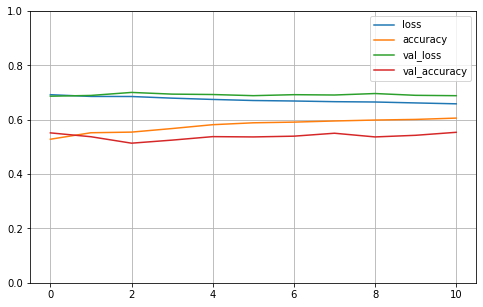

accuracy: 55.37%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 155s 406ms/step - loss: 0.6920 - accuracy: 0.5234 - val_loss: 0.6874 - val_accuracy: 0.5464


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 2/200
350/350 [==============================] - 139s 396ms/step - loss: 0.6881 - accuracy: 0.5402 - val_loss: 0.6837 - val_accuracy: 0.5582


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 3/200
350/350 [==============================] - 140s 401ms/step - loss: 0.6871 - accuracy: 0.5528 - val_loss: 0.6963 - val_accuracy: 0.5392
Epoch 4/200
350/350 [==============================] - 142s 405ms/step - loss: 0.6784 - accuracy: 0.5679 - val_loss: 0.6926 - val_accuracy: 0.5382
Epoch 5/200
350/350 [==============================] - 142s 405ms/step - loss: 0.6748 - accuracy: 0.5796 - val_loss: 0.7120 - val_accuracy: 0.5327
Epoch 6/200
350/350 [==============================] - 142s 406ms/step - loss: 0.6738 - accuracy: 0.5818 - val_loss: 0.6902 - val_accuracy: 0.5473
Epoch 7/200
350/350 [==============================] - 142s 405ms/step - loss: 0.6688 - accuracy: 0.5892 - val_loss: 0.6893 - val_accuracy: 0.5433
Epoch 8/200
350/350 [==============================] - 142s 407ms/step - loss: 0.6668 - accuracy: 0.5928 - val_loss: 0.7224 - val_accuracy: 0.5390
Epoch 9/200
350/350 [==============================] - 142s 406ms/step - loss: 0.6679 - accuracy: 0.5894 - val_loss: 0

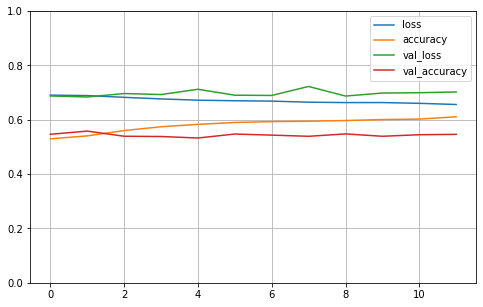

accuracy: 55.82%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 161s 414ms/step - loss: 0.6931 - accuracy: 0.5184 - val_loss: 0.6860 - val_accuracy: 0.5529


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 2/200
350/350 [==============================] - 142s 405ms/step - loss: 0.6898 - accuracy: 0.5373 - val_loss: 0.6895 - val_accuracy: 0.5258
Epoch 3/200
350/350 [==============================] - 143s 408ms/step - loss: 0.6854 - accuracy: 0.5572 - val_loss: 0.6881 - val_accuracy: 0.5404
Epoch 4/200
350/350 [==============================] - 143s 409ms/step - loss: 0.6751 - accuracy: 0.5766 - val_loss: 0.6908 - val_accuracy: 0.5309
Epoch 5/200
350/350 [==============================] - 144s 413ms/step - loss: 0.6778 - accuracy: 0.5757 - val_loss: 0.6943 - val_accuracy: 0.5325
Epoch 6/200
350/350 [==============================] - 145s 414ms/step - loss: 0.6743 - accuracy: 0.5842 - val_loss: 0.6947 - val_accuracy: 0.5364
Epoch 7/200
350/350 [==============================] - 144s 412ms/step - loss: 0.6699 - accuracy: 0.5923 - val_loss: 0.6885 - val_accuracy: 0.5435
Epoch 8/200
350/350 [==============================] - 144s 411ms/step - loss: 0.6699 - accuracy: 0.5934 - val_loss: 0

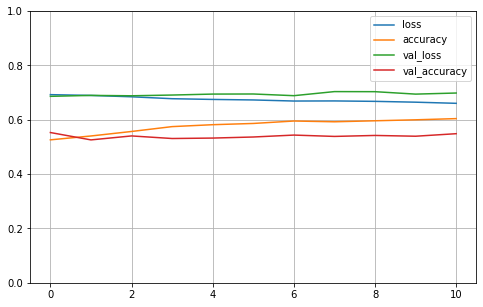

accuracy: 55.29%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 160s 418ms/step - loss: 0.6906 - accuracy: 0.5290 - val_loss: 0.6866 - val_accuracy: 0.5535


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 2/200
350/350 [==============================] - 141s 403ms/step - loss: 0.6885 - accuracy: 0.5343 - val_loss: 0.6929 - val_accuracy: 0.5277
Epoch 3/200
350/350 [==============================] - 142s 407ms/step - loss: 0.6809 - accuracy: 0.5710 - val_loss: 0.6883 - val_accuracy: 0.5353
Epoch 4/200
350/350 [==============================] - 142s 406ms/step - loss: 0.6757 - accuracy: 0.5755 - val_loss: 0.6875 - val_accuracy: 0.5359
Epoch 5/200
350/350 [==============================] - 143s 410ms/step - loss: 0.6742 - accuracy: 0.5860 - val_loss: 0.7005 - val_accuracy: 0.5360
Epoch 6/200
350/350 [==============================] - 143s 410ms/step - loss: 0.6727 - accuracy: 0.5884 - val_loss: 0.6896 - val_accuracy: 0.5306
Epoch 7/200
350/350 [==============================] - 145s 414ms/step - loss: 0.6700 - accuracy: 0.5888 - val_loss: 0.6857 - val_accuracy: 0.5463
Epoch 8/200
350/350 [==============================] - 144s 413ms/step - loss: 0.6684 - accuracy: 0.5908 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 16/200
350/350 [==============================] - 144s 413ms/step - loss: 0.6464 - accuracy: 0.6160 - val_loss: 0.6828 - val_accuracy: 0.5838


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 17/200
350/350 [==============================] - 143s 410ms/step - loss: 0.6444 - accuracy: 0.6225 - val_loss: 0.6926 - val_accuracy: 0.5532
Epoch 18/200
350/350 [==============================] - 144s 412ms/step - loss: 0.6538 - accuracy: 0.6119 - val_loss: 0.6830 - val_accuracy: 0.5778
Epoch 19/200
350/350 [==============================] - 144s 411ms/step - loss: 0.6363 - accuracy: 0.6346 - val_loss: 0.6927 - val_accuracy: 0.5634
Epoch 20/200
350/350 [==============================] - 144s 413ms/step - loss: 0.6494 - accuracy: 0.6206 - val_loss: 0.6894 - val_accuracy: 0.5702
Epoch 21/200
350/350 [==============================] - 145s 415ms/step - loss: 0.6426 - accuracy: 0.6341 - val_loss: 0.6271 - val_accuracy: 0.6521


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 22/200
350/350 [==============================] - 146s 417ms/step - loss: 0.5393 - accuracy: 0.7320 - val_loss: 0.5811 - val_accuracy: 0.7012


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 23/200
350/350 [==============================] - 145s 415ms/step - loss: 0.5006 - accuracy: 0.7613 - val_loss: 0.5458 - val_accuracy: 0.7188


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 24/200
350/350 [==============================] - 145s 414ms/step - loss: 0.4458 - accuracy: 0.7933 - val_loss: 0.5400 - val_accuracy: 0.7253


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 25/200
350/350 [==============================] - 144s 413ms/step - loss: 0.4082 - accuracy: 0.8210 - val_loss: 0.4918 - val_accuracy: 0.7752


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 26/200
350/350 [==============================] - 144s 411ms/step - loss: 0.3696 - accuracy: 0.8373 - val_loss: 0.4432 - val_accuracy: 0.7904


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 27/200
350/350 [==============================] - 145s 414ms/step - loss: 0.3648 - accuracy: 0.8411 - val_loss: 0.4324 - val_accuracy: 0.8076


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 28/200
350/350 [==============================] - 143s 410ms/step - loss: 0.3164 - accuracy: 0.8642 - val_loss: 0.4164 - val_accuracy: 0.8134


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 29/200
350/350 [==============================] - 145s 414ms/step - loss: 0.3156 - accuracy: 0.8679 - val_loss: 0.4049 - val_accuracy: 0.8202


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 30/200
350/350 [==============================] - 142s 407ms/step - loss: 0.3014 - accuracy: 0.8777 - val_loss: 0.3725 - val_accuracy: 0.8395


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 31/200
350/350 [==============================] - 144s 411ms/step - loss: 0.3271 - accuracy: 0.8613 - val_loss: 0.4301 - val_accuracy: 0.8208
Epoch 32/200
350/350 [==============================] - 144s 412ms/step - loss: 0.3235 - accuracy: 0.8572 - val_loss: 0.4194 - val_accuracy: 0.8187
Epoch 33/200
350/350 [==============================] - 146s 417ms/step - loss: 0.3458 - accuracy: 0.8456 - val_loss: 0.4018 - val_accuracy: 0.8281
Epoch 34/200
350/350 [==============================] - 146s 418ms/step - loss: 0.2962 - accuracy: 0.8760 - val_loss: 0.3854 - val_accuracy: 0.8317
Epoch 35/200
350/350 [==============================] - 147s 421ms/step - loss: 0.3098 - accuracy: 0.8663 - val_loss: 0.3681 - val_accuracy: 0.8402


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 36/200
350/350 [==============================] - 145s 415ms/step - loss: 0.2938 - accuracy: 0.8778 - val_loss: 0.3819 - val_accuracy: 0.8401
Epoch 37/200
350/350 [==============================] - 146s 418ms/step - loss: 0.2701 - accuracy: 0.8855 - val_loss: 0.3812 - val_accuracy: 0.8441


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 38/200
350/350 [==============================] - 146s 416ms/step - loss: 0.2521 - accuracy: 0.8994 - val_loss: 0.3492 - val_accuracy: 0.8487


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 39/200
350/350 [==============================] - 145s 416ms/step - loss: 0.3423 - accuracy: 0.8390 - val_loss: 0.4707 - val_accuracy: 0.7802
Epoch 40/200
350/350 [==============================] - 145s 416ms/step - loss: 0.3804 - accuracy: 0.8255 - val_loss: 0.4049 - val_accuracy: 0.8223
Epoch 41/200
350/350 [==============================] - 146s 416ms/step - loss: 0.3082 - accuracy: 0.8706 - val_loss: 0.3955 - val_accuracy: 0.8270
Epoch 42/200
350/350 [==============================] - 145s 415ms/step - loss: 0.3553 - accuracy: 0.8396 - val_loss: 0.4615 - val_accuracy: 0.7893
Epoch 43/200
350/350 [==============================] - 145s 415ms/step - loss: 0.3365 - accuracy: 0.8528 - val_loss: 0.4537 - val_accuracy: 0.7932
Epoch 44/200
350/350 [==============================] - 145s 414ms/step - loss: 0.3170 - accuracy: 0.8656 - val_loss: 0.3919 - val_accuracy: 0.8223
Epoch 45/200
350/350 [==============================] - 146s 418ms/step - loss: 0.2875 - accuracy: 0.8793 - val_

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 48/200
350/350 [==============================] - 146s 418ms/step - loss: 0.2578 - accuracy: 0.8924 - val_loss: 0.3637 - val_accuracy: 0.8441
Epoch 49/200
350/350 [==============================] - 147s 420ms/step - loss: 0.2639 - accuracy: 0.8911 - val_loss: 0.3674 - val_accuracy: 0.8466
Epoch 50/200
350/350 [==============================] - 146s 417ms/step - loss: 0.2512 - accuracy: 0.8995 - val_loss: 0.3436 - val_accuracy: 0.8585
Epoch 51/200
350/350 [==============================] - 147s 421ms/step - loss: 0.2713 - accuracy: 0.8910 - val_loss: 0.4371 - val_accuracy: 0.8249
Epoch 52/200
350/350 [==============================] - 147s 421ms/step - loss: 0.2700 - accuracy: 0.8838 - val_loss: 0.3391 - val_accuracy: 0.8613


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 53/200
350/350 [==============================] - 147s 420ms/step - loss: 0.2402 - accuracy: 0.8992 - val_loss: 0.3759 - val_accuracy: 0.8586
Epoch 54/200
350/350 [==============================] - 146s 418ms/step - loss: 0.2503 - accuracy: 0.8933 - val_loss: 0.3598 - val_accuracy: 0.8473
Epoch 55/200
350/350 [==============================] - 147s 419ms/step - loss: 0.2310 - accuracy: 0.9070 - val_loss: 0.7231 - val_accuracy: 0.5888
Epoch 56/200
350/350 [==============================] - 141s 404ms/step - loss: 0.3502 - accuracy: 0.8410 - val_loss: 0.3643 - val_accuracy: 0.8494
Epoch 57/200
350/350 [==============================] - 136s 389ms/step - loss: 0.2422 - accuracy: 0.9019 - val_loss: 0.3601 - val_accuracy: 0.8447
Epoch 58/200
350/350 [==============================] - 133s 379ms/step - loss: 0.2459 - accuracy: 0.8979 - val_loss: 0.3580 - val_accuracy: 0.8550
Epoch 59/200
350/350 [==============================] - 135s 385ms/step - loss: 0.2439 - accuracy: 0.9034 - val_

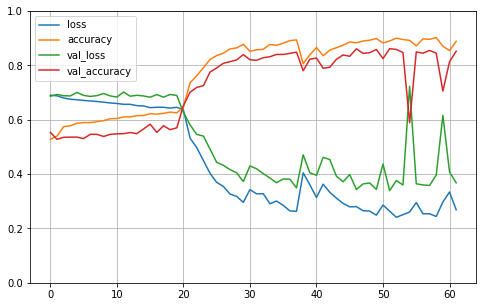

accuracy: 86.13%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 147s 384ms/step - loss: 0.6925 - accuracy: 0.5274 - val_loss: 0.6914 - val_accuracy: 0.5222


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 2/200
350/350 [==============================] - 132s 378ms/step - loss: 0.6902 - accuracy: 0.5359 - val_loss: 0.6854 - val_accuracy: 0.5541


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 3/200
350/350 [==============================] - 132s 377ms/step - loss: 0.6856 - accuracy: 0.5500 - val_loss: 0.6926 - val_accuracy: 0.5221
Epoch 4/200
350/350 [==============================] - 129s 368ms/step - loss: 0.6778 - accuracy: 0.5699 - val_loss: 0.6905 - val_accuracy: 0.5245
Epoch 5/200
350/350 [==============================] - 132s 376ms/step - loss: 0.6729 - accuracy: 0.5855 - val_loss: 0.6960 - val_accuracy: 0.5312
Epoch 6/200
350/350 [==============================] - 128s 365ms/step - loss: 0.6690 - accuracy: 0.5891 - val_loss: 0.6882 - val_accuracy: 0.5412
Epoch 7/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6663 - accuracy: 0.5977 - val_loss: 0.6912 - val_accuracy: 0.5499
Epoch 8/200
350/350 [==============================] - 129s 370ms/step - loss: 0.6646 - accuracy: 0.6035 - val_loss: 0.6859 - val_accuracy: 0.5525
Epoch 9/200
350/350 [==============================] - 132s 377ms/step - loss: 0.6630 - accuracy: 0.5986 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 12/200
350/350 [==============================] - 130s 372ms/step - loss: 0.6521 - accuracy: 0.6169 - val_loss: 0.6855 - val_accuracy: 0.5588
Epoch 00012: early stopping
Fold 5, 200 epochs, 1651 sec


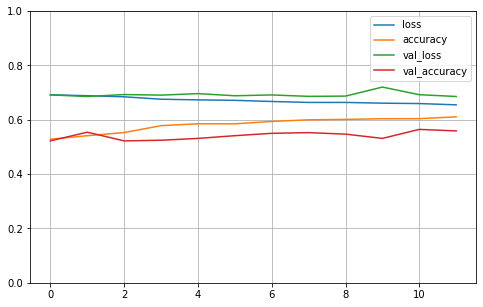

accuracy: 56.44%

5-way Cross Validation max 86.13%, mean 61.81% (+/- 12.17%)
Done


In [8]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model,X_valid,y_valid)  
print ("Done")